# TM10007 Assignment template

In this part of the code a connection is made between github and this file.
All the documents from github are imported, inluding our data.
The files that are not needed for our assignment were deleted from github.

In [16]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git
!pip install fast_ml --upgrade

  Preparing metadata (setup.py) ... done


## Data loading

Loading the data in. And extracting basic data. And splitting data in label and features.


In [19]:
# Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data
import pandas as pd
data = load_data()

# Printing the demensions of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

#splitting data into X and y
y  = data['label']
X = data[data.columns[1:]]
y = pd.DataFrame(y)
X = pd.DataFrame(X)
print(f'The number of samples: {len(X.index)}')
print(f'The number of samples: {len(y.index)}')
# Counting the different labels
def ratio_lipoma_liposarcoma(y):
  lipoma = 0
  liposarcoma = 0
  for i in y['label']:
    if i == "lipoma":
      lipoma += 1
    else:
      liposarcoma += 1
  return f'Ratio van lipoma and liposarcoma is: {lipoma} : {liposarcoma}'
print(ratio_lipoma_liposarcoma(y))

The number of samples: 115
The number of columns: 494
The number of samples: 115
The number of samples: 115
Ratio van lipoma and liposarcoma is: 57 : 58


# Splitting the data into training and test

We will split the data in a training en test set with the following ratio 4:1 (training:test).



In [20]:
from sklearn.model_selection import train_test_split
# making the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Train {ratio_lipoma_liposarcoma(y_train)}')
print(f'Test {ratio_lipoma_liposarcoma(y_test)}')

Train Ratio van lipoma and liposarcoma is: 45 : 47
Test Ratio van lipoma and liposarcoma is: 12 : 11


# Checking for duplicateds
In this code a check will be conducted to check if there are any duplicate features or rows.




In [22]:
# check of there are no duplicated features and rows by using the index
if  data.index.is_unique:
  print('Features and rows are unique')
else:
  print('There is a duplicated features and/or rows')

#check of there are no dupliceted features regarding the data
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_duplicate_features
print(f'The number of columns: {len(X_train.columns)}')
print(f'The number of columns: {len(X_test.columns)}')

duplicate_features = get_duplicate_features(X_train)
duplicate_features.head()
duplicate_features_list = duplicate_features.query("Desc=='Duplicate Values'")['feature2'].to_list()
X_train.drop(columns = duplicate_features_list, inplace=True)
X_test.drop(columns = duplicate_features_list, inplace=True)
print(f'The number of columns: {len(X_train.columns)}')
print(f'The number of columns: {len(X_test.columns)}')

Features and rows are unique
The number of columns: 493
The number of columns: 493
The number of columns: 467
The number of columns: 467


#Checking for variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# Sample DataFrame X
# X = ...

# Create an instance of VarianceThreshold
selector = VarianceThreshold()

# Fit the selector to your data
selector.fit(X_train)

# Get the indices of the features that are kept after feature selection
kept_features_indices = selector.get_support(indices=True)

# Get the names of the kept features
kept_features_names = X_train.columns[kept_features_indices]

# Transform the data and create a new DataFrame with the kept features
relevant_features = selector.transform(X_train)
X_selected_train = pd.DataFrame(relevant_features, columns=kept_features_names)

# Print the original DataFrame, transformed DataFrame, and the number of zero-variance features
print("\nNumber of zero-variance features:", X_train.shape[1] - X_selected.shape[1])

# Transform the test set using the same selector
relevant_features_test = selector.transform(X_test)
X_selected_test = pd.DataFrame(relevant_features_test, columns=kept_features_names)


# Data checking datatype
Checking the data types used for the futeres and analyzing the int data

In [7]:
X_train.info()
# want to have the name of the int to check if it is a catogirsed data
integer_features = X.select_dtypes(include='int64').columns.tolist()
print("Integer features:")
print(integer_features)

# all the features constisted _position_ so ch
position_features = [col for col in X.columns if '_position_' in col]
print("Features containing '_position_':")
print(position_features)
position_features = set(position_features)
integer_features = set(integer_features)
print("Feature that are not a duplicated:")
print(integer_features-position_features)
print()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Lipo-032_0 to Lipo-103_0
Columns: 493 entries, PREDICT_original_sf_compactness_avg_2.5D to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25)
memory usage: 355.1+ KB
Integer features:
['PREDICT_original_hf_peak_position', 'PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_logf_peak_position_sigma5', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_tf_LBP_peak_position_R8_P24', 'PREDICT_original_tf_LBP_peak_position_R15_P36', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A1.57', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A2.36', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A1.57', 'PREDICT_original_tf_Gabor_p

Want to make a plot of all the int data to see if it is catogrozied data.


KeyError: 'PREDICT_original_phasef_phasesym_peak_position_WL3_N5'

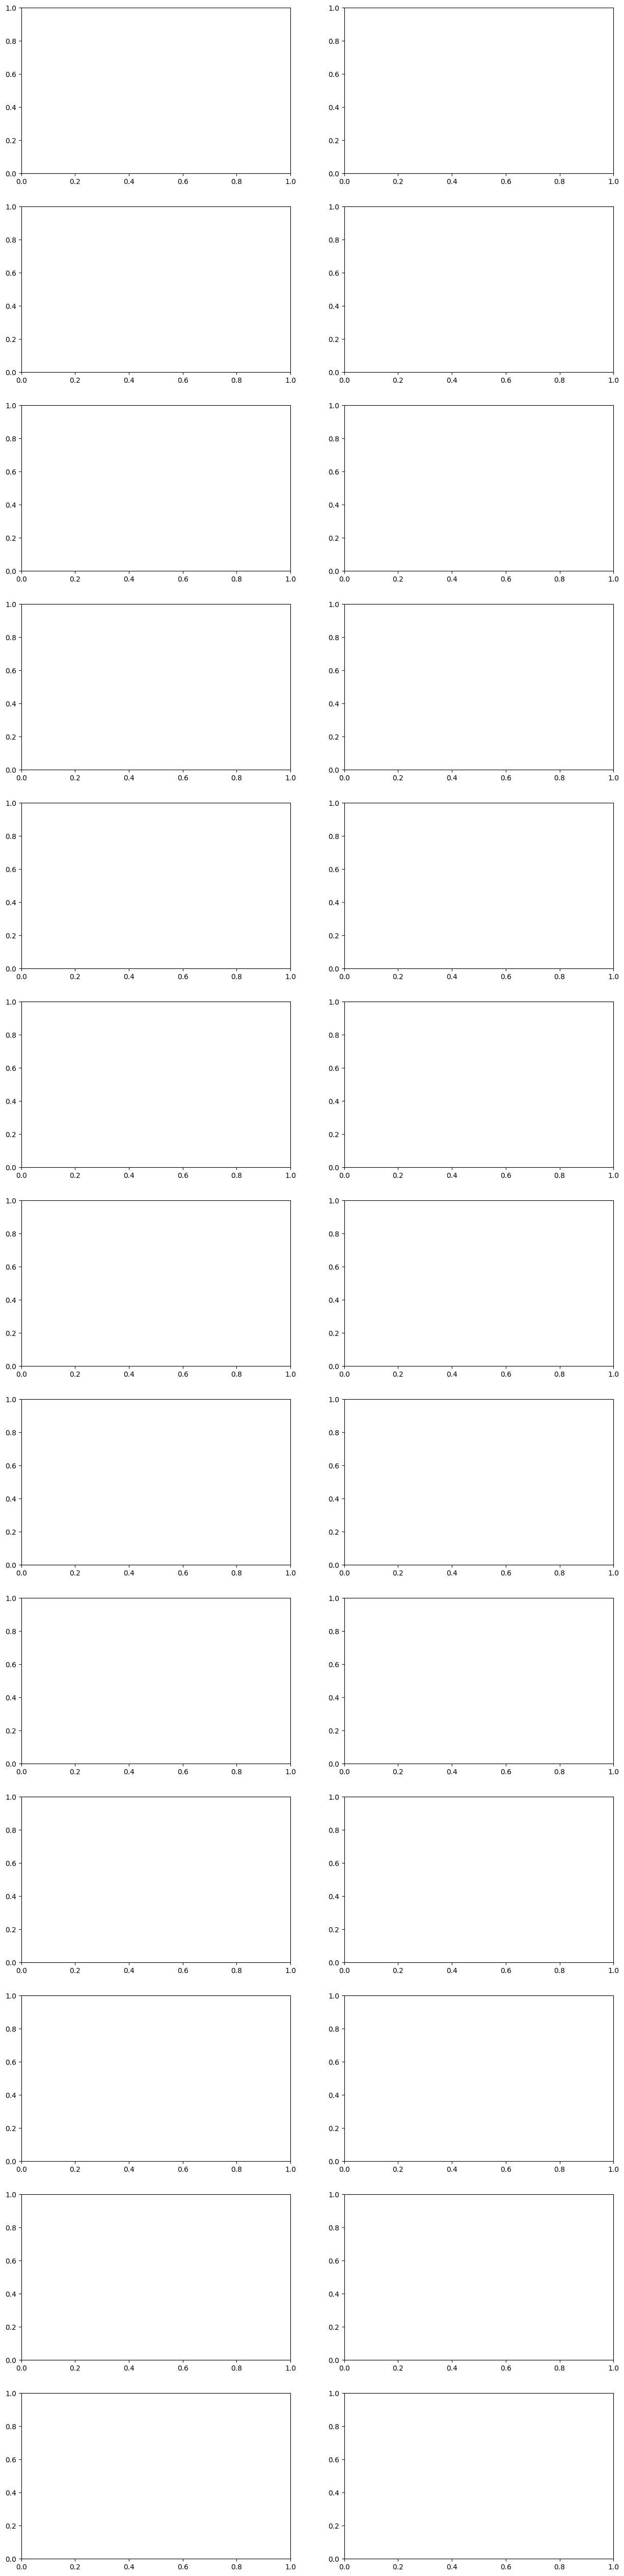

In [62]:
import matplotlib.pyplot as plt

# Assuming features_set is your set of features
num_features = len(integer_features)
num_cols = 2  # Number of columns in the subplot grid
num_rows = -(-num_features // num_cols)  # Ceiling division to calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, feature in enumerate(integer_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    X_selected[feature].plot(kind='hist', bins=20, ax=axes[row, col], title=feature)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    # Annotate each bar with its count
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

# Hide empty subplots if the number of features is not a multiple of num_cols
for i in range(num_features, num_rows*num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# Check if there is missing data
the code will make a heat map for missing data

In [ ]:
missing_values = data.isnull().any()  # Check if any missing values exist in each column
missing_features = missing_values[missing_values]  # Filter only the features with missing values
print("Features with missing values:")
print(missing_features)

#Dimensionality reduction


In [ ]:
# code for dimensionality reduction